---
# Phoenix Temperatures Time Series Mini Project 
---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# no yelling in the library
import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=13)

import acquire as a

In [5]:
s = a.get_data()

In [6]:
s.head()

Date
1835-01-01    52.7792
1835-02-01    52.5416
1835-03-01    57.7544
1835-04-01    65.1974
1835-05-01    73.5656
Name: AverageTemperature, dtype: float64

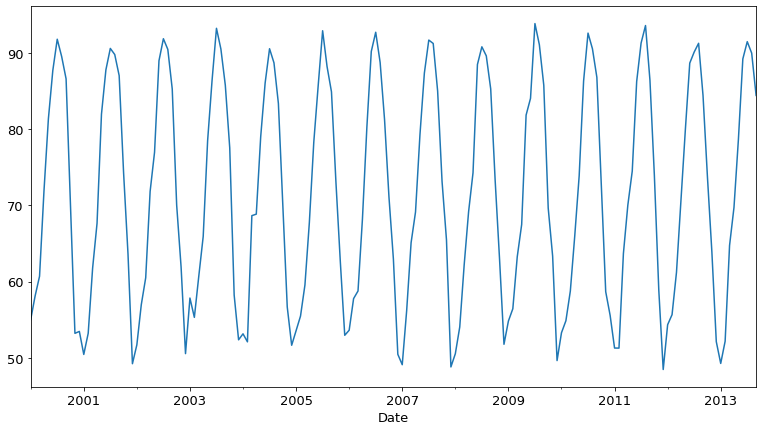

In [8]:
s['2000':].plot();